In [23]:
from sklearn.datasets import fetch_openml
import joblib

# Uncomment to download the dataset for the first time (takes about 30 seconds)
# mnist = fetch_openml('mnist_784', version=1)
# joblib.dump(mnist, "mnist.pkl")

mnist = joblib.load("mnist.pkl")
mnist.keys()

['mnist.pkl']

In [2]:
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [3]:
y.shape

(70000,)

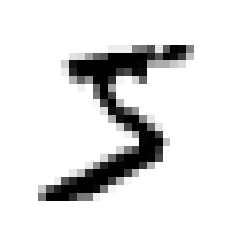

In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X.values[0]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()

In [5]:
y[0]

'5'

In [6]:
import numpy as np
y = y.astype(np.uint8)

In [7]:
X_train, X_test, y_train, y_test = X.values[:60000], X.values[60000:], y.values[:60000], y.values[60000:]

In [8]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [9]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

sgd_clf.predict([some_digit])

array([ True])

In [27]:
# Custom implementation of Cross-Validation

from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9669
0.91625
0.96785


In [31]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")


array([0.95035, 0.96035, 0.9604 ])

In [47]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [48]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

In [49]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [50]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

# output:
#                            Predicted    Predicted
#                         as non-fives:   as fives:        
# Actual images of non-fives:  [[53892,   687],
# Actual images of fives:       [ 1891,  3530]]
#
#                               [[TN,  FP]
#                                [FN,  TP]]
#


array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

In [51]:
y_train_perfect_predictions = y_train_5 # pretend we reached perfection
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

In [52]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [53]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

In [54]:
# F1 is the "harmonic mean". The regular mean gives equal weight to all values, but the harmonic mean gives more
#  weight to low values. You have to have a high values for both precision and recall to have a good F1 score, or
# more specifically, the F1 score favors classifiers that have a similar precision and recall.

from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343846

In [55]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [57]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [58]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [59]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

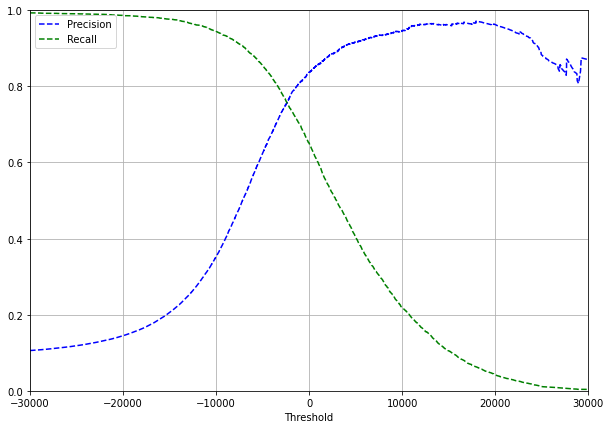

In [100]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.figure(figsize=(10,7))    
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g--", label="Recall")
    plt.legend()
    plt.xlabel("Threshold")
    plt.grid()

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.axis([-30000, 30000, 0, 1])

plt.show()

3370.0194991439557
0.9000345901072293
0.4799852425751706


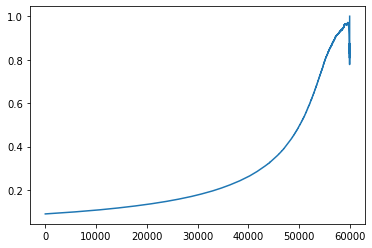

In [133]:
# Obtaining the threshhold for a given precision or recall

# What's happening here is a little obscure. It is based on the fact that precision_recall_curve() returned all the
# possible precision values in ascending order. Since we are calling argmax on an array of bools there is now "max" and
# it just returns the index of the first True it finds. Thus we use argmax to find the exact threshhold that gives us 
# 90% precision.

plt.plot(precisions)

threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
print(threshold_90_precision)
y_train_pred_90 = (y_scores >= threshold_90_precision)
print(precision_score(y_train_5, y_train_pred_90))
print(recall_score(y_train_5, y_train_pred_90))

In [89]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

# AUC (Area Under the Curve) should range from 0.5 (the random classifier) to 1.0 (perfect)

0.9604938554008616

## How to choose between ROC curve and Precision-Recall curve

In most cases, we prefer to evaluate based on the ROC curve. However, if you care a lot about false positives (which are highlighted by Precision), or as in our case the postive class is rare, the P-R curve can illustrate this more dramatically. For example, we have a very high ROC AUC, but this is only because 5's occur just 10% of the time. We know from our P-R curve that Precision and Recall are only about 73% when they are equal and tradeoff is fairly steep after that, so there is actually a lot of room for improvement with this classifier.

Note: F1 is the preferred metric for summarizing the P-R curve.

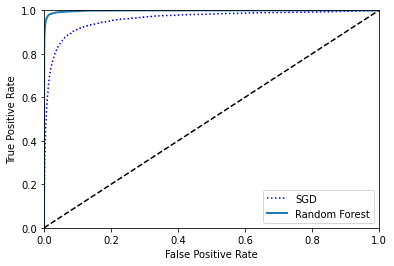

In [90]:
# Compare now with Random Forest Classifier

from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

# Random Forest's predict_proba method returns an n x c matrix, where it has a column showing the probability for each class
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")

In [91]:
from sklearn.metrics import f1_score

y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)

sgd_auc = roc_auc_score(y_train_5, y_scores)
forest_auc = roc_auc_score(y_train_5, y_scores_forest)
sgd_f1 = f1_score(y_train_5, y_train_pred)
forest_f1 = f1_score(y_train_5, y_train_pred_forest)

print(f"SGD AUC: {sgd_auc}")
print(f"Forest AUC: {forest_auc}")
print(f"SGD F1: {sgd_f1}")
print(f"Forest F1: {forest_f1}")

SGD AUC: 0.9604938554008616
Forest AUC: 0.9983436731328145
SGD F1: 0.7325171197343846
Forest F1: 0.9242275142688446


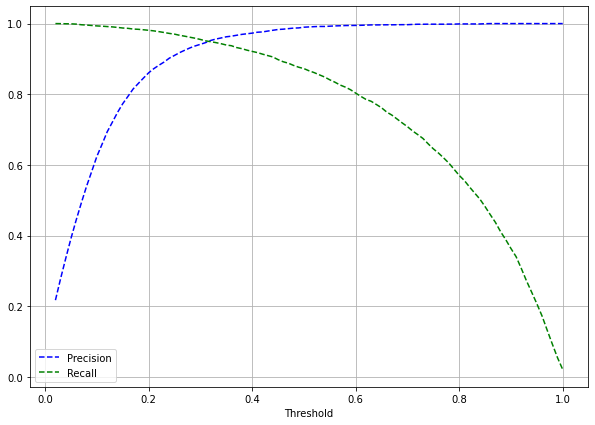

In [148]:
precisions_f, recalls_f, thresholds_f = precision_recall_curve(y_train_5, y_scores_forest)

plot_precision_recall_vs_threshold(precisions_f, recalls_f, thresholds_f)
plt.show()

In [158]:
print(len(y_scores_forest))
print(len(thresholds_f))

# There's an interesting quirk happening here. We're supposed to get a threshold for each
# instance in our training set, but in this case we get very few. There is a small note
# in the docs that mentions that we only get a number of thresholds equal to the unique
# scores given to precision_recall_curve(): https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_curve.html


60000
99
